In [1]:
import os
import sys
sys.path.append('/archive/bioinformatics/')
from DLLab.src.shared.distribution.DLLablib.preamble import notebook; notebook()

import glob
import re
import numpy as np
import pandas as pd
idx = pd.IndexSlice
from scipy import signal
import nibabel
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
from DLLab.AlexTreacher.src import paths

import bids

Machine node: NucleusA250
Python interpreter: /project/bioinformatics/DLLab/shared/CondaEnvironments/Alex37General/bin/python 	
 ver 3.7.10 (default, Feb 26 2021, 18:47:35) 
[GCC 7.3.0]
Current dir: /endosome/archive/bioinformatics/DLLab/src/AlexTreacher/autism_DCG/notebooks
Conda env: /project/bioinformatics/DLLab/shared/CondaEnvironments/Alex37General


In [2]:
strABIDE1MetaFile = strDataPath+'20210825_ABIDE_CPAC/ABIDEI/ABIDEI_meta.csv'
strABIDE2MetaFile = strDataPath+'/20210825_ABIDE_CPAC/ABIDEII/ABIDEII_meta.csv'
strDerivativeDir = '<path_to>/ExperimentOutputs/Autism_DCG/20210908_derivative_summary'
strOutputDir = '<path_to>/ExperimentOutputs/Autism_DCG/20210914_remove_poor_alignment_and_add_meta'

In [3]:
dfData = pd.read_csv(os.path.join(strDerivativeDir, 'desc-3_alff.csv'))
dOutlier = dfData['fraction of zeros in BA'].quantile(.75)+1.5*(dfData['fraction of zeros in BA'].quantile(.75)-dfData['fraction of zeros in BA'].quantile(.25))
print(dOutlier)

0.0024589672337617


### Organize the meta data

In [4]:
dfMetaA1 = pd.read_csv(strABIDE1MetaFile)
dfMetaA2 = pd.read_csv(strABIDE2MetaFile)

In [5]:
dfMetaA1 = dfMetaA1[['SITE_ID','SUB_ID','DX_GROUP','AGE_AT_SCAN','SEX']]
dfMetaA1['ABIDE'] = 1
dfMetaA2 = dfMetaA2[['SITE_ID','SUB_ID','DX_GROUP','AGE_AT_SCAN','SEX']]
dfMetaA2['ABIDE'] = 2
dfMeta = pd.concat([dfMetaA1, dfMetaA2])

In [6]:
dfMeta

,SITE_ID,SUB_ID,DX_GROUP,AGE_AT_SCAN,SEX,ABIDE
0,CALTECH,51456,1,55.4000,1,1
1,CALTECH,51457,1,22.9000,1,1
2,CALTECH,51458,1,39.2000,1,1
3,CALTECH,51459,1,22.8000,1,1
4,CALTECH,51460,1,34.6000,2,1
...,...,...,...,...,...,...
1109,ABIDEII-USM_1,29523,2,36.1451,1,2
1110,ABIDEII-USM_1,29524,2,11.7892,1,2
1111,ABIDEII-USM_1,29525,2,23.2909,1,2
1112,ABIDEII-USM_1,29526,2,32.6242,1,2


### Look at outliers for based on the alighnment

{'whiskers': [<matplotlib.lines.Line2D at 0x2aaae23a2b50>,
 'caps': [<matplotlib.lines.Line2D at 0x2aaae2b06410>,
 'boxes': [<matplotlib.lines.Line2D at 0x2aaae23a2710>],
 'medians': [<matplotlib.lines.Line2D at 0x2aaae2b06cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2aaae2b11150>],
 'means': []}

([<matplotlib.axis.XTick at 0x2aaae236a810>], [Text(1, 0, 'subject')])

Text(0, 0.5, 'Fraction of non-overlapping voxels')

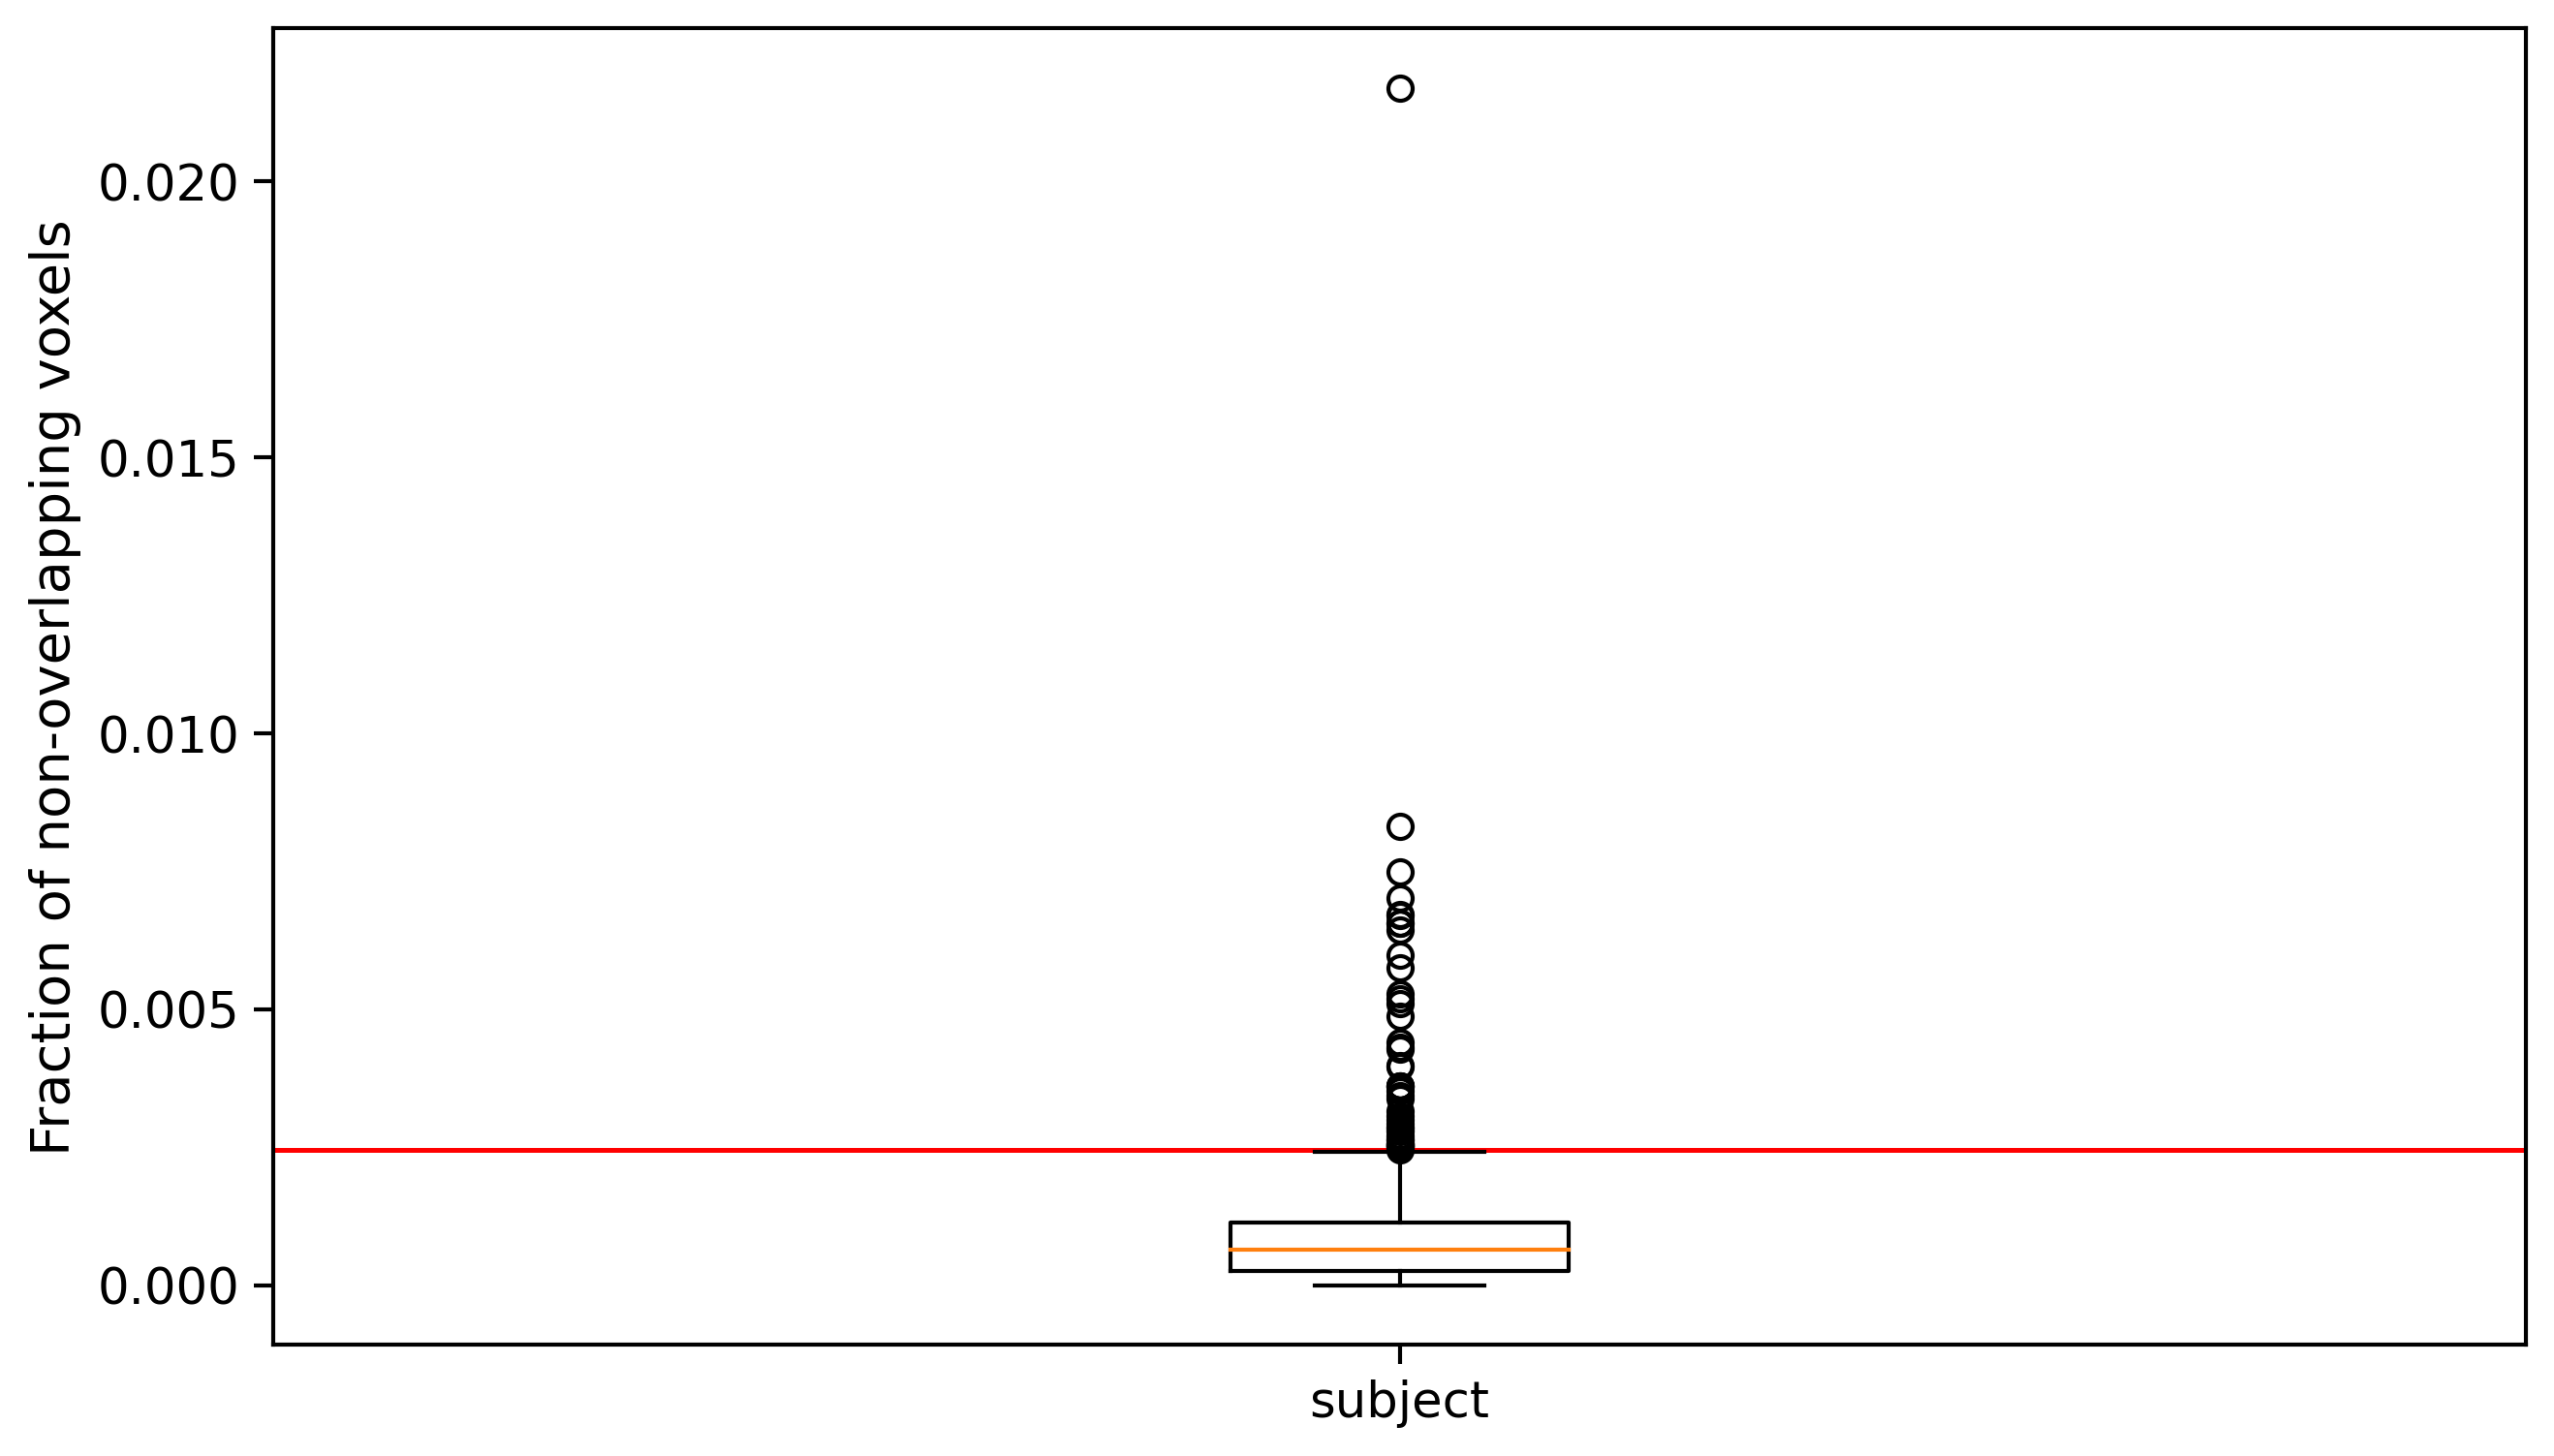

In [7]:
plt.boxplot(dfData['fraction of zeros in BA'])
plt.hlines(dOutlier, 0.5, 1.5, colors='red')
plt.xticks([1], ['subject'])
plt.ylabel('Fraction of non-overlapping voxels')
plt.savefig(os.path.join(strOutputDir,'Registration_outliers_boxplot.png'))

Text(0.5, 0, 'Subjects, ordered by fraction of non-overlapping voxels')

Text(0, 0.5, 'Fraction of non-overlapping voxels')

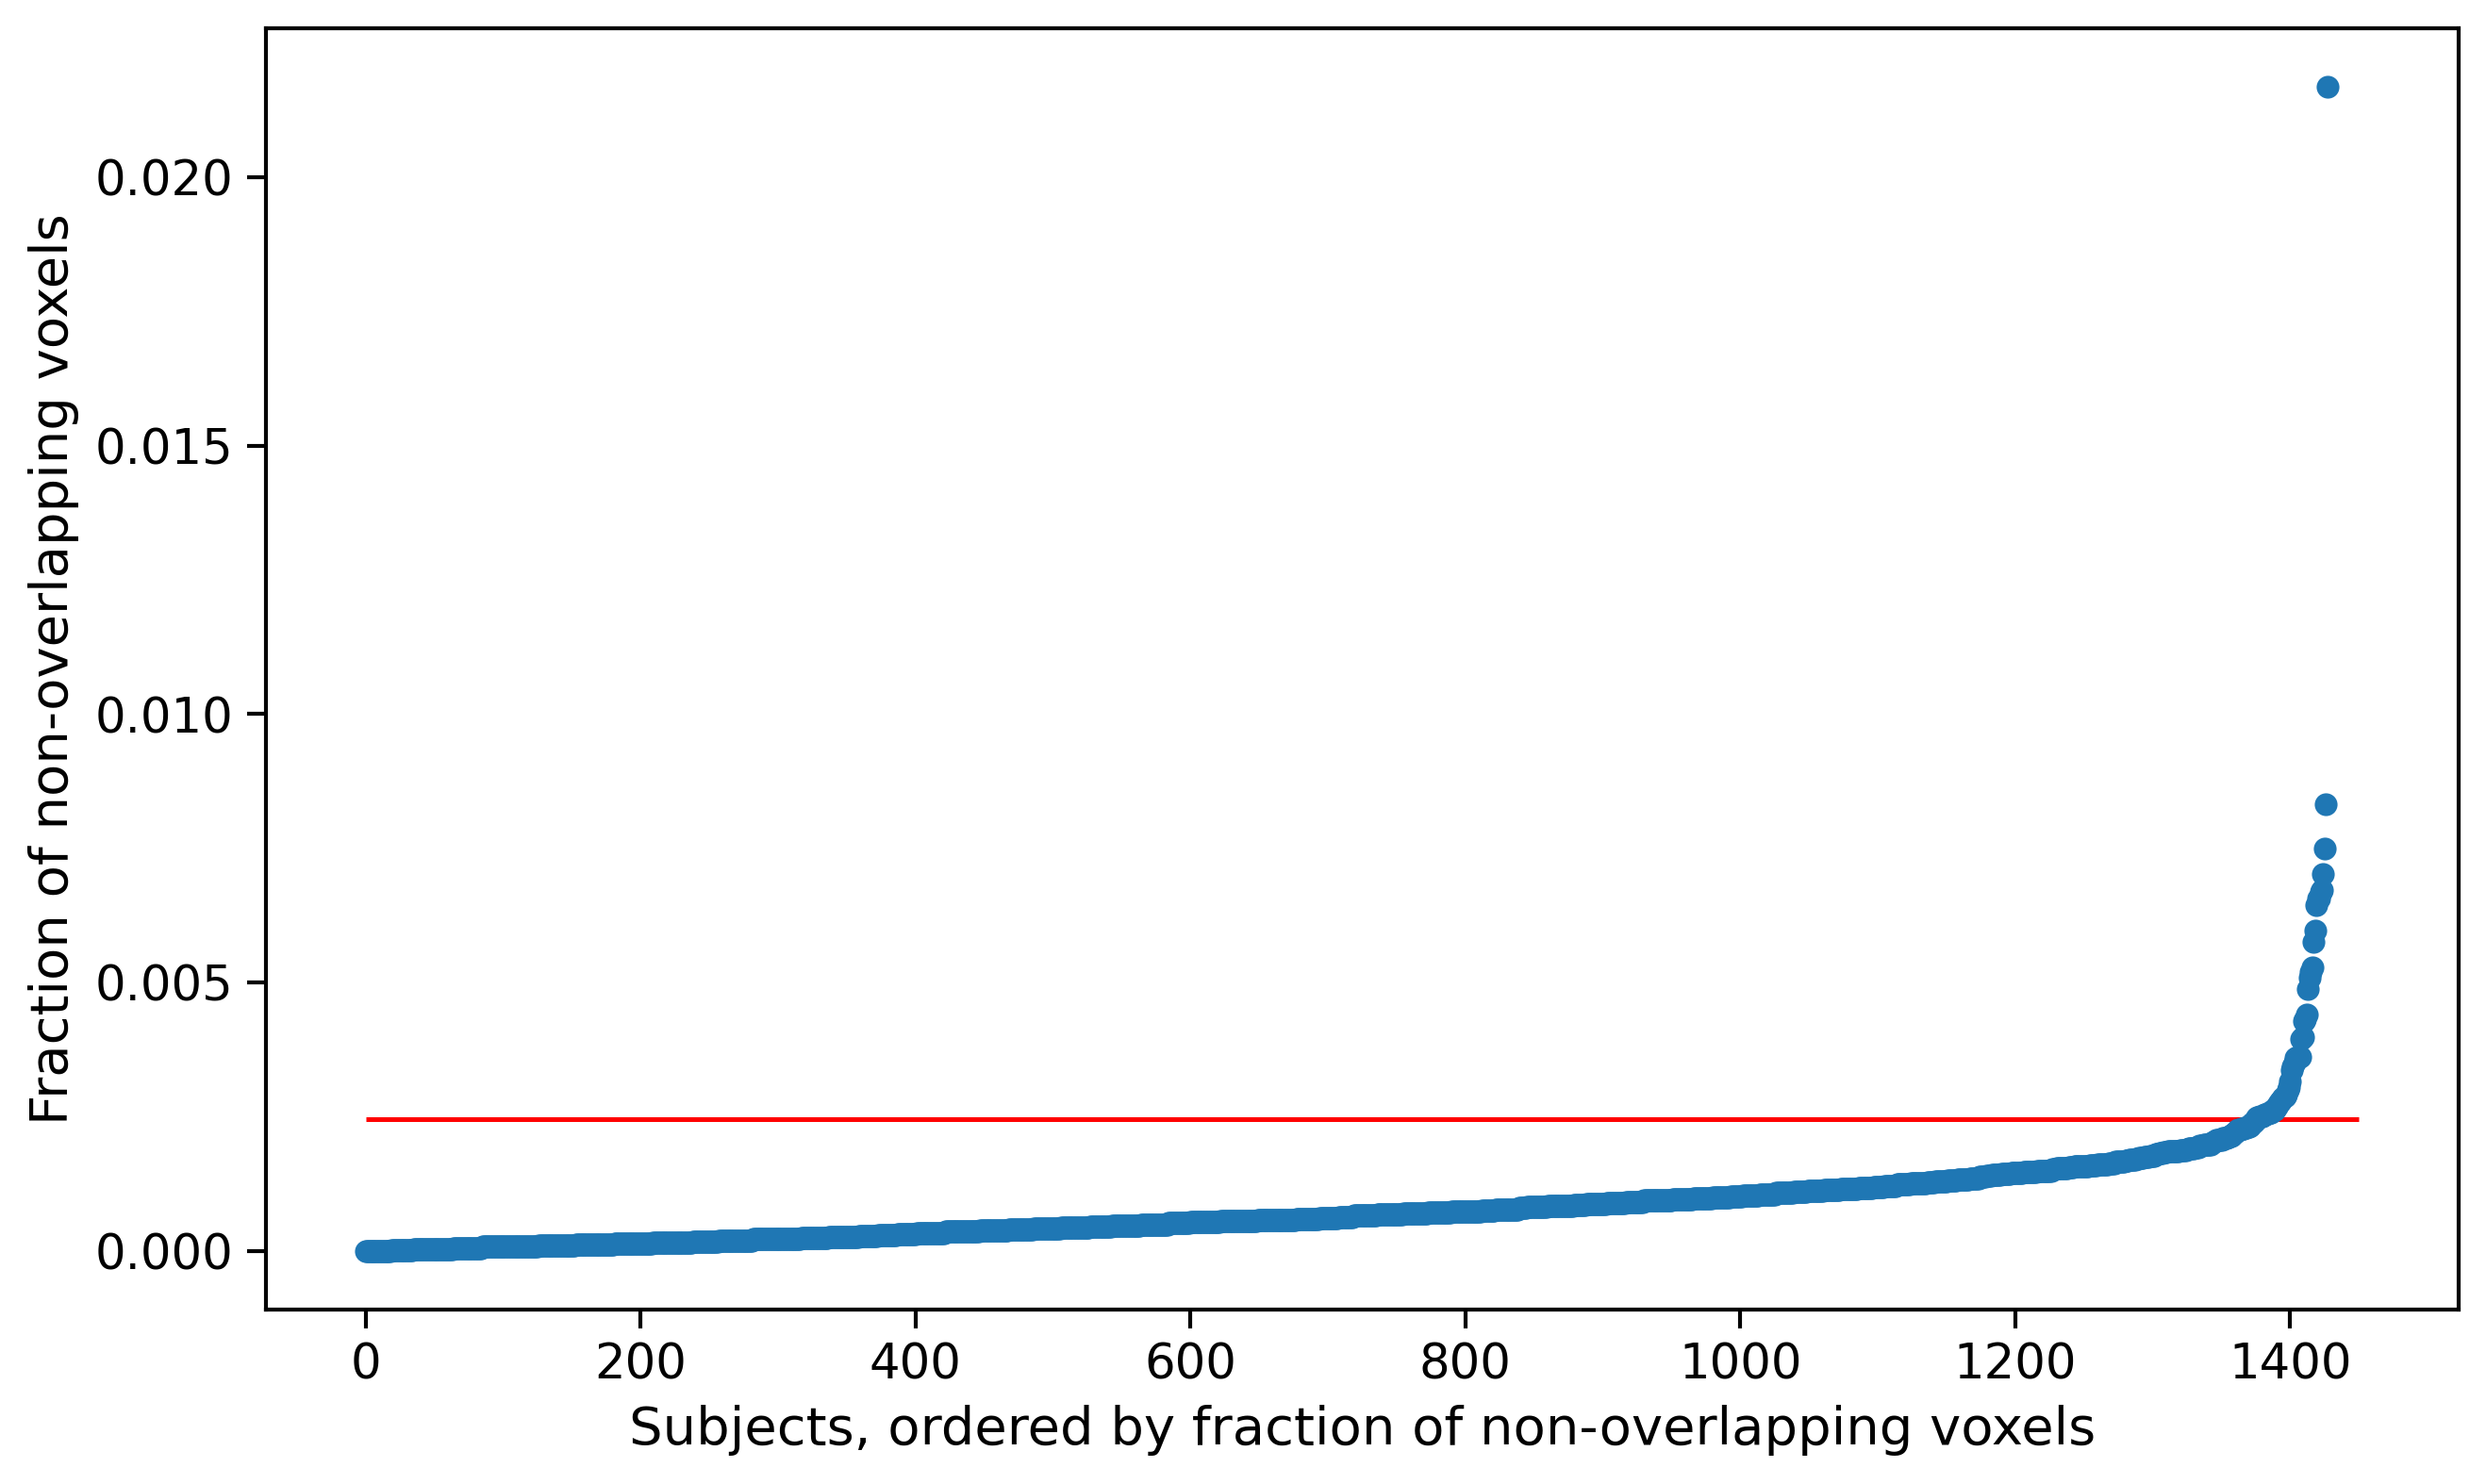

In [8]:
plt.plot(dfData['fraction of zeros in BA'].sort_values().reset_index(drop=True), marker='o', ls='')
plt.hlines(dOutlier, 0, 1450, colors='red')
plt.xlabel('Subjects, ordered by fraction of non-overlapping voxels')
plt.ylabel('Fraction of non-overlapping voxels')
plt.savefig(os.path.join(strOutputDir,'Registration_outliers_elbow_plot.png'))

In [9]:
#get the subjects that are outliers (past the elbow) in order of largest to smallest
lSubjectsToRemove = dfData[dfData['fraction of zeros in BA'] >= dOutlier].sort_values('fraction of zeros in BA', ascending=False)['ABIDE_ID'].tolist()
lSubjectsToRemove.__len__()
lSubjectsToRemove

53

[50727,
 50653,
 51472,
 51457,
 50746,
 50643,
 50736,
 51476,
 51469,
 51470,
 51458,
 51492,
 51462,
 51468,
 51489,
 51486,
 51483,
 51467,
 50732,
 30027,
 50651,
 50648,
 51485,
 29662,
 30011,
 51474,
 29668,
 29796,
 29676,
 50747,
 51460,
 51563,
 29661,
 29666,
 50772,
 29557,
 29099,
 50725,
 29109,
 29667,
 29679,
 51581,
 29997,
 50055,
 29084,
 51463,
 29794,
 50692,
 29220,
 51574,
 50666,
 29658,
 29660]

### Read in the ALFF, fALFF, and ReHo summary values, remove the subjects that have are outliers from above, and add the meta data

In [10]:
lFiles = [
    'desc-1_alff.csv',
    'desc-2_alff.csv',
    'desc-3_alff.csv',
    'desc-1_falff.csv',
    'desc-2_falff.csv',
    'desc-3_falff.csv',
    'desc-1_reho.csv',
    'desc-2_reho.csv',
    'desc-3_reho.csv'
]

lColsToAdd = ['DX_GROUP','SEX','AGE_AT_SCAN','SITE_ID']

In [11]:
for strFile in lFiles:
    dfData = pd.read_csv(os.path.join(strDerivativeDir, strFile))

    dfDataFilterd = dfData[dfData['ABIDE_ID'].apply(lambda x: not x in lSubjectsToRemove)]
    #make sure that the number of subjects that have been removed match the number of subjects that are listed to be removed
    assert dfData.shape[0] - dfDataFilterd.shape[0] == lSubjectsToRemove.__len__()
    #add the meta data 
    for strCol in lColsToAdd[::-1]:
        dfData.insert(2, strCol, np.nan)

    for i, row in dfData.iterrows():
        dfSubjectMeta = dfMeta[(dfMeta['SUB_ID'] == row['ABIDE_ID']) & (dfMeta['ABIDE'] == row['ABIDE'])]
        assert dfSubjectMeta.shape[0] == 1
        for strCol in lColsToAdd:
            dfData.loc[i, strCol] = dfSubjectMeta.iloc[0][strCol]

    dfData.to_csv(os.path.join(strOutputDir, strFile))